# Simple plagiarism check 
### Note:  The app is yet able to check similarity only

This is the sketch for the idea of my back-end thesis product (in progress for front-end and back-end).

The idea of the project is to:
* Open the document
* Extract Hyperlinks (references)
* Store the HyperLinks in the Local Database
* Scrape data from each HyperLink
* Compare the similarity of the self-writing document with data scraped from HyperLinks
* Take the mean -> Percentage of plagiarism

**Future**:
* Improve the speed with big data
* Return copied text

# Preparation

In [1]:
import numpy as np
import PyPDF2
from docx.opc.constants import RELATIONSHIP_TYPE as RT
from docx import Document
import urllib
import pymysql
from bs4 import BeautifulSoup  
import requests, io, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def readFile(doc):
    '''
    Read a text file and return to a elements of a list
    '''
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
        
    return '\n'.join(fullText)    

In [3]:
def onlRefs(rels):
    '''
    Extract all the hyperlinks (references) in the document
    '''
    links = []
    for rel in rels:
        if rels[rel].reltype == RT.HYPERLINK:
            links.append(rels[rel]._target)
            
    return links

In [4]:
def working_with_mySQL(onl_ref_results):
    '''
    Store all the hyperlinks to db
    Library used: pymysql
    '''
    #Open database
    db = pymysql.connect(host = '127.0.0.1',
                          user = 'root',
                           db = 'references')
    
    cursor = db.cursor()   
    
    #check distinct reference to add to the database
    sql = "INSERT INTO onlref (link) VALUES (%s)"
    for link in onl_ref_results:
        try:
            cursor.execute(sql, link)
        except:
            pass
    
    #fetch all the links
    cursor.execute('SELECT link FROM onlref')
    data = cursor.fetchall()

    db.commit()
    db.close()
    
    #append each link into a list
    links = []    
    for link in data:
        links.append(link[0])
    
    return links

In [5]:
def readContent(link):    
    '''
    Depend on the website (pdf or regular html)
    Open the file and scrape the data of 01 site
    Libraries used: 
    bs4 -> BeautifulSoup 
    requests, io, re
    '''
    
    string = []
   
    # if the link is a pdf
    if (re.search(link.split('/')[-1], r'.pdf') is True):
        response = requests.get(link)
        raw_data = response.content
        pdf_content = io.BytesIO(raw_data)
        pdf_reader = PyPDF2.PdfFileReader(pdf_content)
        for page in range(pdf_reader.numPages + 1):
            string.append(pdf_reader.getPage(page).extractText())
        return(' '.join(string))
    
    # if not
    else:
        def scrape_data():
            page = requests.get(link)
            text = BeautifulSoup(page.text, 'html.parser').find_all('p')
            for p in text:
                string.append(p.get_text())
            return(' '.join(string).replace(u'\xa0', ' ').replace(u'\n', ' '))
        
        try:
            return scrape_data()
        
        #some links need authentication
        except:
            
            headers = {'User-Agent':'Mozilla/5.0'}             
            #class AppURLopener(urllib.request.FancyURLopener):
                #version = "Mozilla/5.0"
            #opener = AppURLopener()
            return scrape_data()

In [6]:
def get_all_content(links):
    '''
    Return all the contents into a list y
    '''
    base_refs = []
    for link in links:
        base_refs.append(readContent(link))
        
    return base_refs

In [7]:
def getToken(text):
    '''
    Tokenise + Omit punctuation
    Libraries: 
        nltk.tokenize -> word_tokenize, 
        nltk.corpus -> stopwords,
        string
    '''
    translator = str.maketrans('', '', string.punctuation)
    stopWords = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    filtered = [w for w in tokens if not w in stopWords]
    
    return ' '.join(filtered).translate(translator)

In [8]:
def check_similarity(document):
    '''
    Checking similarity using cosine similarity
    Library: sklearn.feature_extraction.text -> TfidVectorizer
    '''
    vect = TfidfVectorizer(min_df=1)
    similarity = []
    links = working_with_mySQL(onlRefs(rels))
    
    for content in get_all_content(links):
        tfidf = vect.fit_transform([getToken(readFile(document)), content])
        similarity.append((tfidf * tfidf.T).A[0,1])
        
    return np.mean(similarity)

# Running test

In [9]:
path = r'dir\OrganisationalCourse.docx'
_file = path.replace('\\', '/')

In [10]:
#open the docx
document = Document(_file) 
rels = document.part.rels

In [11]:
#Checking if there onlRefs works
#Checking if the document has any references as required
if (len(onlRefs(rels)) == 0):
    print("No ref to check.")
    #raise Error('The document is missing references')
else:
    print("Great work!")

Great work!


#### Calculate The similarity + Plot the executing time

In [12]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
times = []
time_observed = []
result = []
for i in range(20):
    start = time.time()
    result.append(check_similarity(document))
    end = time.time()
    time_observed.append(end-start)
    times.append(i)

Average executing time: 25.2688 seconds
Similarity percentage:  0.0637


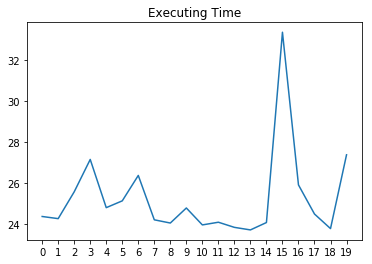

In [14]:
plt.xticks(np.arange(20), times);
plt.plot(times, time_observed);
plt.title("Executing Time")

print("Average executing time:" , round(np.mean(time_observed), 4), "seconds")
print("Similarity percentage: ", round(np.mean(result), 4))